In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import trompy as tp

from scipy import stats
from scipy.spatial.distance import pdist, squareform, euclidean

import dill

rcParams['font.family'] = 'Arial'
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.transparent'] = True
colors = ["#67AFD2", "#016895", "#F4795B", "#C74632"]

savefigs = False

DATAFOLDER = Path("..//data")
RESULTSFOLDER = Path("..//results")
FIGSFOLDER = Path("C:/Users/jmc010/Dropbox/Publications in Progress/Bazzino Roitman_sodium/figs")

In [2]:
with open(DATAFOLDER / "bazzino_data_for_frejus.pickle", "rb") as f:
    data = dill.load(f)

x_array = data["x_array"]
snips_photo = data["snips_photo"]
snips_vel = data["snips_vel"]

In [4]:
pcafile = RESULTSFOLDER / "transformed_data_photo.pickle"

with open(pcafile, 'rb') as f:
    pca = dill.load(f)

pc1 = pca[:,0]
pca_data = pca[:, :3]

In [5]:
pca_data.shape

(1960, 3)

In [60]:
from scipy.spatial.distance import cdist

# calculate centroids
cluster_0_centroid = pca_data[x_array.cluster_photo == 0].mean(axis=0)
cluster_1_centroid = pca_data[x_array.cluster_photo == 1].mean(axis=0)


## First, to work out projections
# Step 2: Define the cluster separation vector
cluster_vector = cluster_0_centroid - cluster_1_centroid

# Step 3: Project each observation onto the cluster vector
# Normalize the cluster vector
cluster_vector_norm = cluster_vector / np.linalg.norm(cluster_vector)
# Compute projections
projections = np.dot(pca_data - cluster_1_centroid, cluster_vector_norm)

# Step 4: Normalize the projections to range between 0 and 1
min_projection = projections.min()
max_projection = projections.max()
normalized_projections = (projections - min_projection) / (max_projection - min_projection)

x_array = x_array.assign(clusterness_photo=normalized_projections)


## Second to work out Euclidian distances
# Stack centroids into a matrix
centroids = np.vstack([cluster_0_centroid, cluster_1_centroid])

# Calculate all distances at once using cdist
# This creates a matrix where each row is an observation and each column is a centroid
distances = cdist(pca_data, centroids, metric='euclidean')

distances_diff = distances[:, 1] - distances[:, 0]

x_array = x_array.assign(euclidean_diff=distances_diff)



<Axes: ylabel='Frequency'>

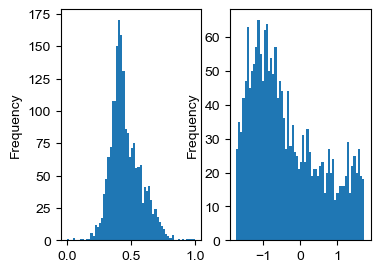

In [63]:
f, ax = plt.subplots(figsize=(4,3), ncols=2)

(x_array
 # .query("infusiontype == '45NaCl' & condition == 'deplete'")
 .clusterness_photo
 .plot.hist(bins=60, ax=ax[0])
)

(x_array
 # .query("infusiontype == '45NaCl' & condition == 'deplete'")
 .euclidean_diff
 .plot.hist(bins=60, ax=ax[1])
)

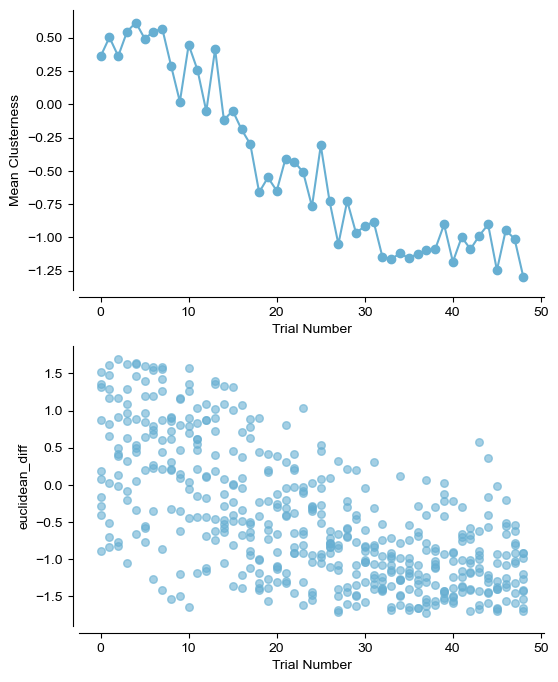

In [65]:
f, [ax1, ax2] = plt.subplots(nrows=2, figsize=(6, 8))

(x_array
.query("infusiontype == '45NaCl' & condition == 'deplete'")
.groupby("trial")
#.clusterness_photo
.euclidean_diff
.mean()
.plot(ax=ax1, color=colors[0], marker='o', linestyle='-')
)

ax1.set_ylabel("Mean Clusterness")

(x_array
.query("infusiontype == '45NaCl' & condition == 'deplete'")
.plot(ax=ax2, kind="scatter",
      # x="trial", y="clusterness_photo",
      x="trial", y="euclidean_diff",
      color=colors[0],
      alpha=0.6, s=30)
# .scatter(x="trial", y="clusterness_photo")
)

for axis in [ax1, ax2]:
    axis.set_xlabel("Trial Number")
    sns.despine(ax=axis, offset=5)


<Axes: xlabel='trial', ylabel='clusterness_photo'>

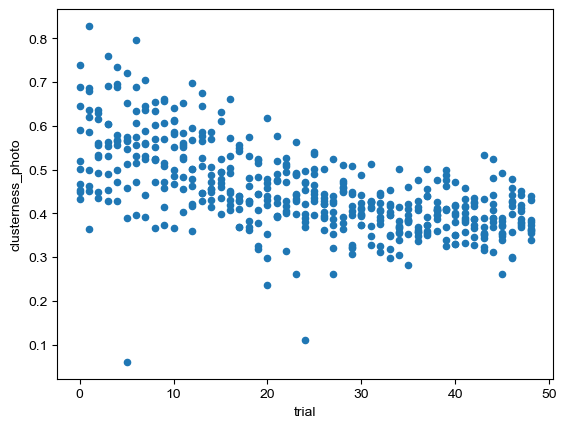

In [50]:
(x_array
.query("infusiontype == '45NaCl' & condition == 'deplete'")
.plot.scatter(x="trial", y="clusterness_photo")
)

In [12]:
from scipy.ndimage import gaussian_filter1d

x_array_red = x_array.query("infusiontype == '45NaCl' & condition == 'deplete'")
rats = x_array_red.id.unique()

for rat in rats:
    mask = x_array.id == rat
    clusterness = x_array.loc[mask, 'clusterness_photo'].values
    
    # Apply Gaussian smoothing
    smoothed = gaussian_filter1d(clusterness, sigma=2)  # Adjust sigma
    x_array.loc[mask, 'clusterness_photo_smoothed'] = smoothed

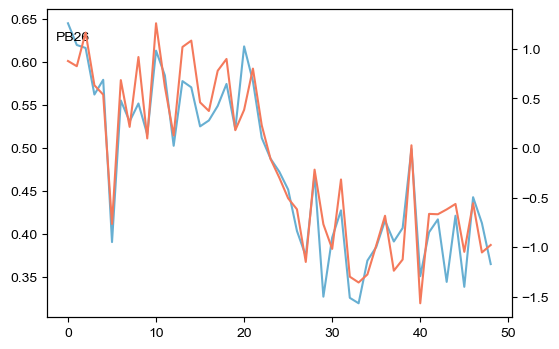

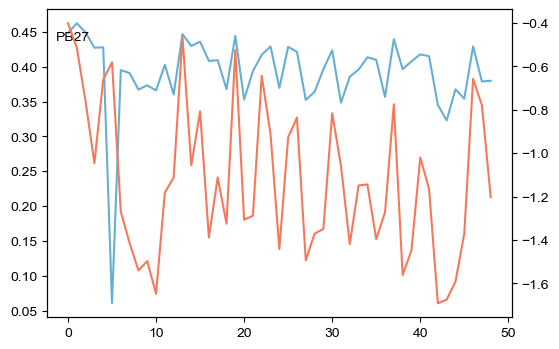

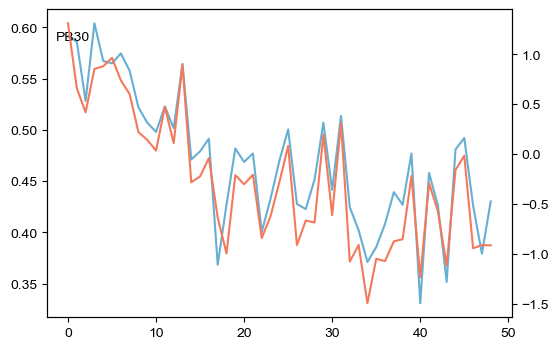

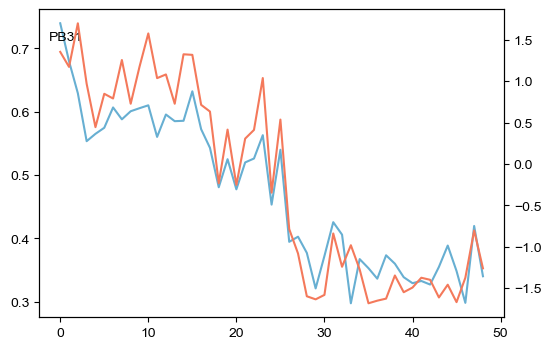

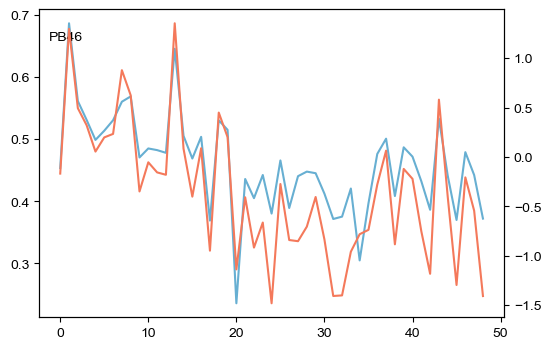

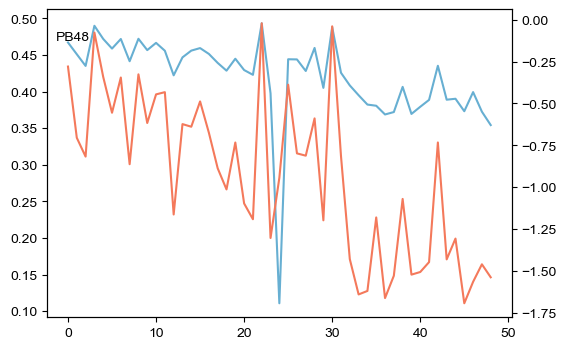

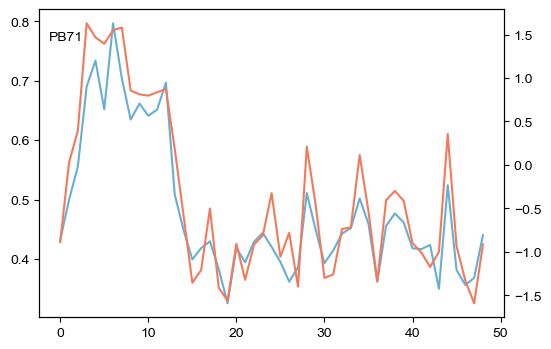

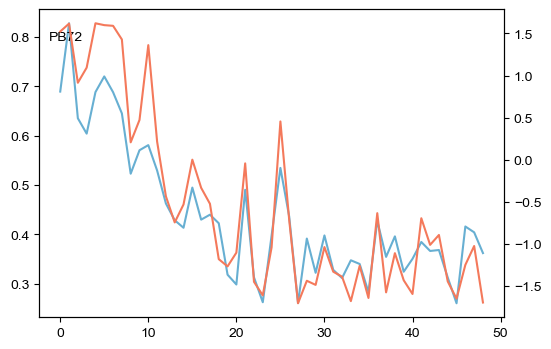

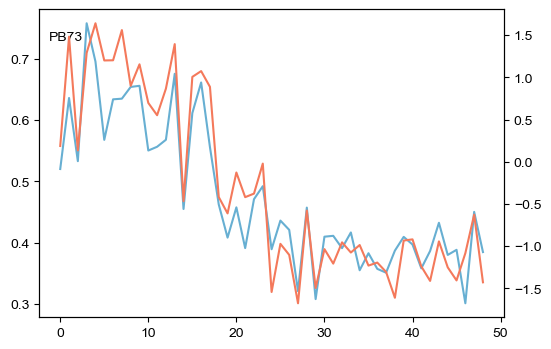

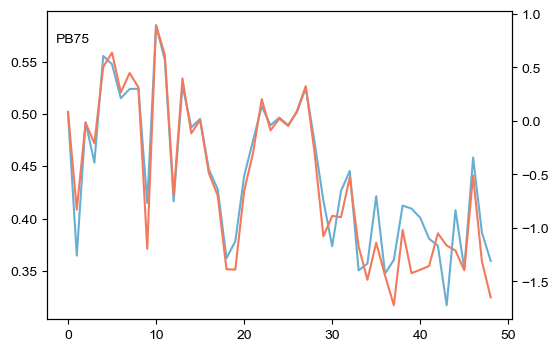

In [71]:
# just select 0.45 and deplete Na+ condition
x_array_red = x_array.query("infusiontype == '45NaCl' & condition == 'deplete'")
rats = x_array_red.id.unique()

for rat in rats:
        x_rat = x_array_red.query("id == @rat")
#     snips_photo_rat = snips_photo[x_array.query("infusiontype == '45NaCl' & condition == 'deplete' & id == @rat").index]
#     snips_vel_rat = snips_vel[x_array.query("infusiontype == '45NaCl' & condition == 'deplete' & id == @rat").index]
    # pc1_rat = pc1[x_array.query("infusiontype == '45NaCl' & condition == 'deplete' & id == @rat").index]

        f, ax = plt.subplots(figsize=(6,4), sharex=True)

        ax.plot(x_rat.trial, x_rat
        .clusterness_photo,
        color=colors[0], label='Photo'
        )

        ax.text(0.02, 0.9, rat, transform=ax.transAxes)
        ax2 = ax.twinx()

        ax2.plot(x_rat.trial, x_rat
        .euclidean_diff,
        color=colors[2], label='Photo'
        )
    
    



C:\Users\jmc010\AppData\Local\Temp\ipykernel_30852\16501507.py:18: RuntimeWarning: invalid value encountered in power
  return L / (1 + nu * np.exp(-k * (x - x0)))**(1/nu)


Fitted parameters: [ 0.56108767 -1.24877795 15.97283339 91.56559848]


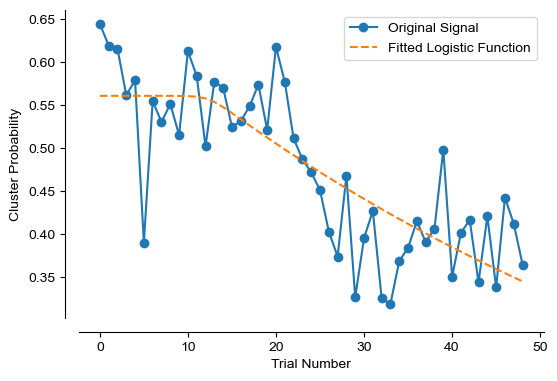

In [75]:
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Define logistic function
def logistic(x, L, x0, k):
    return L / (1 + np.exp(-k * (x - x0)))

def hill(x, L, K, n):
    return L * (x**n) / (K**n + x**n)

def richards(x, L, k, x0, nu):
    """
    L: upper asymptote
    k: growth rate
    x0: inflection point
    nu: affects asymmetry (nu=1 gives standard logistic)
    """
    return L / (1 + nu * np.exp(-k * (x - x0)))**(1/nu)

# Example signal with smooth transitions
x = np.linspace(0, 10, 100)
signal = 1 / (1 + np.exp(-(x - 5)))  # Logistic function

signal = x_array.query("condition == 'deplete' & infusiontype == '45NaCl' & id == 'PB26'").clusterness_photo
x = np.arange(len(signal))

# Fit logistic function to the signal
popt, _ = curve_fit(logistic, x, signal, p0=[0.6, 25, -0.5])  # Initial guesses for L, x0, k

try:
    popt, _ = curve_fit(richards, x, signal, p0=[1, 1, 25, 1])  # Initial guesses for L, x0, k
except RuntimeError:
    print("Richards function fit failed")

# Plot the signal and the fitted function
f, ax = plt.subplots(figsize=(6, 4))
ax.plot(x, signal, label="Original Signal", marker="o")
# ax.plot(x, logistic(x, *popt), label="Fitted Logistic Function", linestyle="--")
ax.plot(x, richards(x, *popt), label="Fitted Logistic Function", linestyle="--")
ax.legend()
ax.set_xlabel("Trial Number")
ax.set_ylabel("Cluster Probability")
# ax.set_ylim([1,-0.1])
# ax.set_yticks([0, 0.5, 1], labels=["1", "0.5", "0"])

sns.despine(ax=ax, offset=10)

print("Fitted parameters:", popt)

In [77]:
signal.values

array([0.64491553, 0.61963237, 0.61618637, 0.5619514 , 0.57910825,
       0.39018201, 0.55500576, 0.53056827, 0.55151732, 0.5154265 ,
       0.61303319, 0.58425537, 0.50229085, 0.5775782 , 0.57031929,
       0.52488854, 0.53176621, 0.5486741 , 0.57427245, 0.52154968,
       0.61803705, 0.57751657, 0.51149475, 0.48732696, 0.4719985 ,
       0.45133799, 0.40310998, 0.37399936, 0.46818393, 0.32661888,
       0.39550796, 0.42709479, 0.3252759 , 0.3189267 , 0.36864938,
       0.38435401, 0.41514902, 0.39083102, 0.406537  , 0.49853543,
       0.35044863, 0.40163026, 0.41661253, 0.34383276, 0.42084516,
       0.3380906 , 0.44244458, 0.41226175, 0.36456185])

Logistic fit:
  L=0.1692, x0=23.84, k=-0.9126, offset=0.3899
  R² = 0.7451
  Inflection point at trial 23.8

Gompertz fit:
  L=0.1686, k=-0.6720, x0=24.58, offset=0.3906
  R² = 0.7440
  Inflection point at trial 24.6


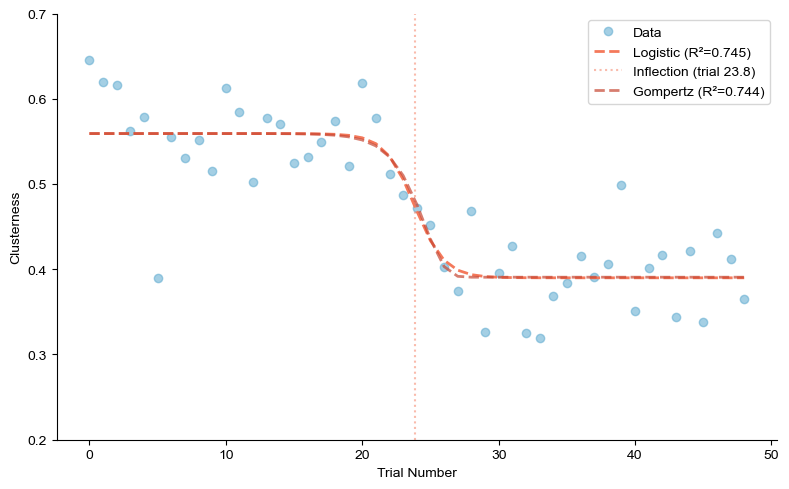

In [78]:
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt

# Your data
signal = np.array([0.64491553, 0.61963237, 0.61618637, 0.5619514 , 0.57910825,
       0.39018201, 0.55500576, 0.53056827, 0.55151732, 0.5154265 ,
       0.61303319, 0.58425537, 0.50229085, 0.5775782 , 0.57031929,
       0.52488854, 0.53176621, 0.5486741 , 0.57427245, 0.52154968,
       0.61803705, 0.57751657, 0.51149475, 0.48732696, 0.4719985 ,
       0.45133799, 0.40310998, 0.37399936, 0.46818393, 0.32661888,
       0.39550796, 0.42709479, 0.3252759 , 0.3189267 , 0.36864938,
       0.38435401, 0.41514902, 0.39083102, 0.406537  , 0.49853543,
       0.35044863, 0.40163026, 0.41661253, 0.34383276, 0.42084516,
       0.3380906 , 0.44244458, 0.41226175, 0.36456185])

x = np.arange(len(signal))

# Define sigmoid functions
def logistic(x, L, x0, k, offset):
    """
    L: amplitude of change
    x0: inflection point
    k: steepness (negative for decreasing)
    offset: lower asymptote
    """
    return L / (1 + np.exp(-k * (x - x0))) + offset

def gompertz(x, L, k, x0, offset):
    """
    Gompertz function - good for asymmetric sigmoids
    """
    return L * np.exp(-np.exp(-k * (x - x0))) + offset

# Try logistic fit with 4 parameters (better for data with clear upper and lower bounds)
try:
    # Initial guesses: [amplitude, inflection_point, steepness, lower_asymptote]
    # For decreasing: negative steepness, start high, end low
    p0_logistic = [0.25, 15, -0.2, 0.35]  # amplitude, x0, k, offset
    popt_log, pcov_log = curve_fit(logistic, x, signal, p0=p0_logistic, maxfev=10000)
    
    y_fit_log = logistic(x, *popt_log)
    ss_res_log = np.sum((signal - y_fit_log) ** 2)
    ss_tot = np.sum((signal - np.mean(signal)) ** 2)
    r2_log = 1 - (ss_res_log / ss_tot)
    
    print("Logistic fit:")
    print(f"  L={popt_log[0]:.4f}, x0={popt_log[1]:.2f}, k={popt_log[2]:.4f}, offset={popt_log[3]:.4f}")
    print(f"  R² = {r2_log:.4f}")
    print(f"  Inflection point at trial {popt_log[1]:.1f}")
except Exception as e:
    print(f"Logistic fit failed: {e}")
    popt_log = None

# Try Gompertz (often better for asymmetric decreasing curves)
try:
    p0_gomp = [-0.25, -0.15, 15, 0.35]  # L, k, x0, offset
    popt_gomp, pcov_gomp = curve_fit(gompertz, x, signal, p0=p0_gomp, maxfev=10000)
    
    y_fit_gomp = gompertz(x, *popt_gomp)
    ss_res_gomp = np.sum((signal - y_fit_gomp) ** 2)
    r2_gomp = 1 - (ss_res_gomp / ss_tot)
    
    print("\nGompertz fit:")
    print(f"  L={popt_gomp[0]:.4f}, k={popt_gomp[1]:.4f}, x0={popt_gomp[2]:.2f}, offset={popt_gomp[3]:.4f}")
    print(f"  R² = {r2_gomp:.4f}")
    print(f"  Inflection point at trial {popt_gomp[2]:.1f}")
except Exception as e:
    print(f"Gompertz fit failed: {e}")
    popt_gomp = None

# Plot
f, ax = plt.subplots(figsize=(8, 5))
ax.plot(x, signal, 'o', label="Data", color=colors[0], alpha=0.6, markersize=6)

if popt_log is not None:
    ax.plot(x, y_fit_log, '--', label=f"Logistic (R²={r2_log:.3f})", 
            color=colors[2], linewidth=2)
    ax.axvline(popt_log[1], color=colors[2], linestyle=':', alpha=0.5, 
               label=f'Inflection (trial {popt_log[1]:.1f})')

if popt_gomp is not None:
    ax.plot(x, y_fit_gomp, '--', label=f"Gompertz (R²={r2_gomp:.3f})", 
            color=colors[3], linewidth=2, alpha=0.7)

ax.set_xlabel("Trial Number")
ax.set_ylabel("Clusterness")
ax.legend()
ax.set_ylim([0.2, 0.7])
sns.despine(ax=ax)
plt.tight_layout()
plt.show()


PB26 - Logistic fit:
  L=0.1692, x0=23.84, k=-0.9126, offset=0.3899
  R² = 0.7451
  Inflection point at trial 23.8
PB26 - Gompertz fit:
  L=0.1686, k=-0.6720, x0=24.58, offset=0.3906
  R² = 0.7440
  Inflection point at trial 24.6


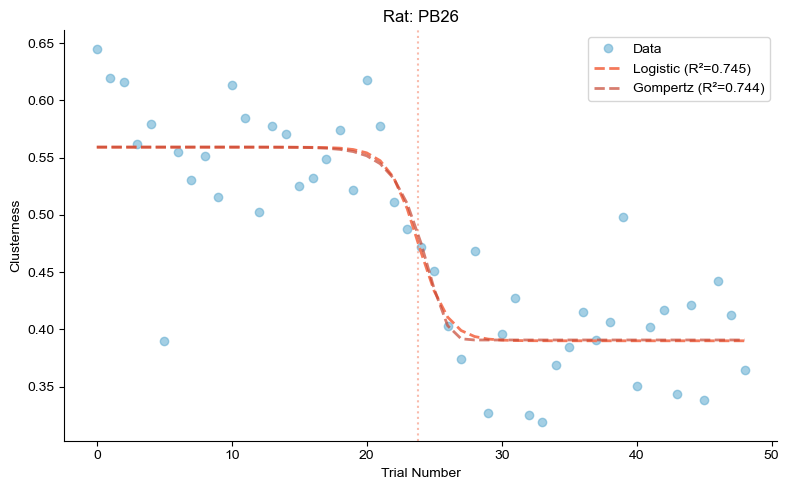


PB27 - Logistic fit failed: Optimal parameters not found: Number of calls to function has reached maxfev = 10000.
PB27 - Gompertz fit:
  L=0.0028, k=-0.4510, x0=-9.08, offset=0.3915
  R² = 0.6155
  Inflection point at trial -9.1


C:\Users\jmc010\AppData\Local\Temp\ipykernel_30852\3279083962.py:53: OptimizeWarning: Covariance of the parameters could not be estimated
  popt_gomp, pcov_gomp = curve_fit(gompertz, x, signal, p0=p0_gomp, maxfev=10000)


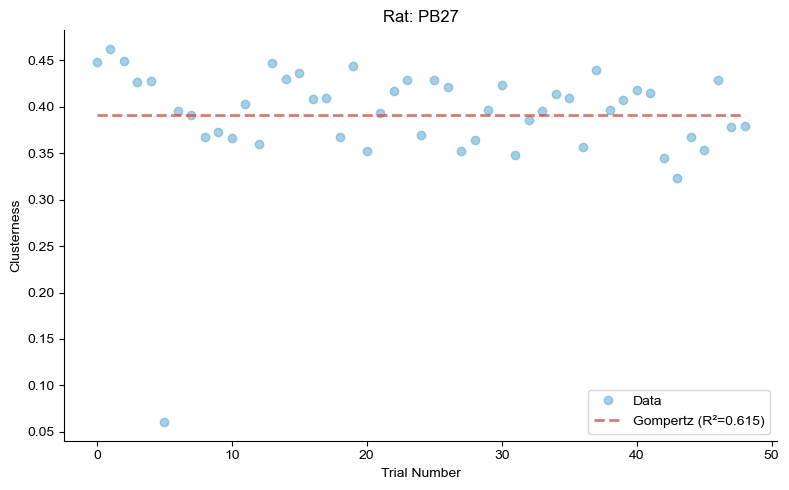


PB30 - Logistic fit:
  L=0.2052, x0=8.77, k=-0.1577, offset=0.4258
  R² = 0.6306
  Inflection point at trial 8.8
PB30 - Gompertz fit:
  L=0.6379, k=-0.0395, x0=-6.81, offset=0.4242
  R² = 0.6277
  Inflection point at trial -6.8


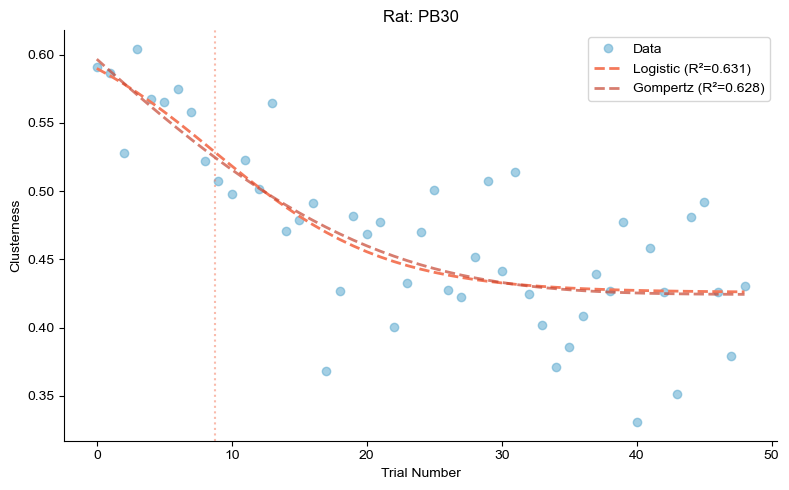


PB31 - Logistic fit:
  L=0.2766, x0=22.83, k=-0.2240, offset=0.3412
  R² = 0.8749
  Inflection point at trial 22.8
PB31 - Gompertz fit:
  L=0.2815, k=-0.1483, x0=24.92, offset=0.3483
  R² = 0.8800
  Inflection point at trial 24.9


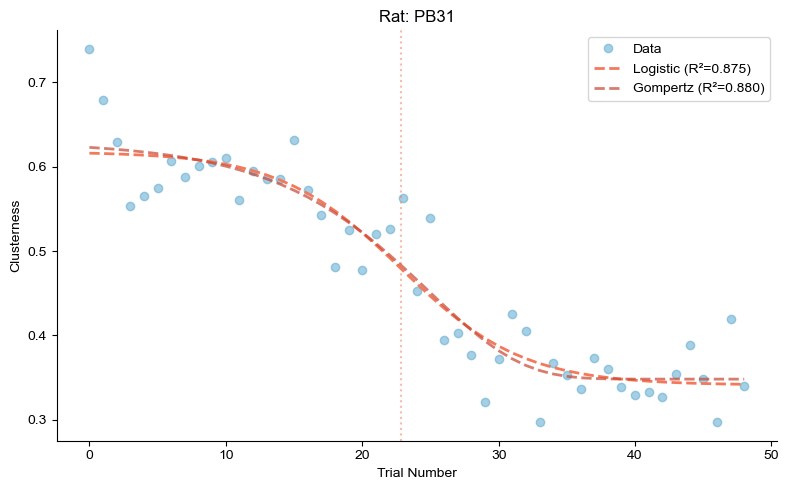


PB46 - Logistic fit:
  L=0.1077, x0=15.74, k=-1.0761, offset=0.4240
  R² = 0.3832
  Inflection point at trial 15.7
PB46 - Gompertz fit:
  L=0.1123, k=-0.4184, x0=17.00, offset=0.4227
  R² = 0.3842
  Inflection point at trial 17.0


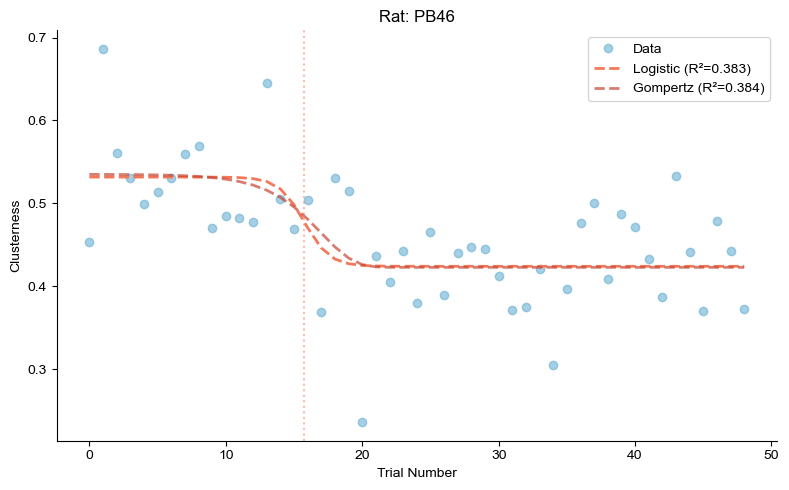


PB48 - Logistic fit:
  L=0.0932, x0=19.09, k=-0.1259, offset=0.3824
  R² = 0.2510
  Inflection point at trial 19.1
PB48 - Gompertz fit:
  L=0.1351, k=-0.0488, x0=19.35, offset=0.3790
  R² = 0.2493
  Inflection point at trial 19.4


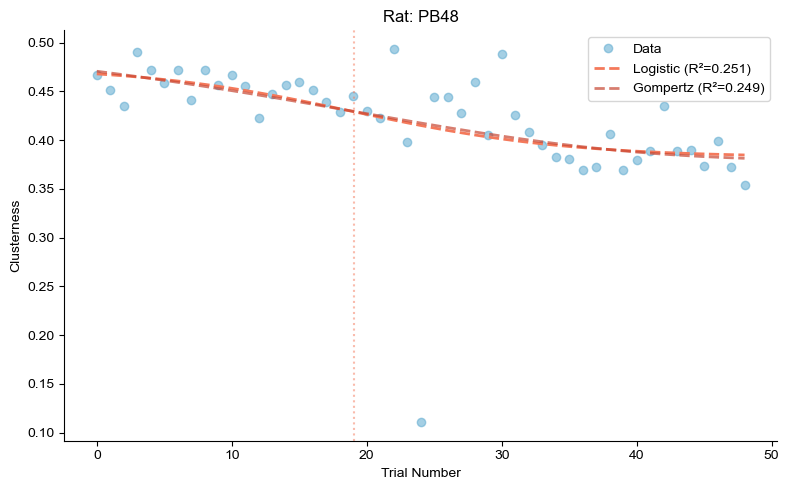


PB71 - Logistic fit:
  L=0.2219, x0=12.98, k=-20.4892, offset=0.4204
  R² = 0.7155
  Inflection point at trial 13.0
PB71 - Gompertz fit:
  L=-0.2222, k=2.4406, x0=12.75, offset=0.6422
  R² = 0.7161
  Inflection point at trial 12.8


C:\Users\jmc010\AppData\Local\Temp\ipykernel_30852\3279083962.py:13: RuntimeWarning: overflow encountered in exp
  return L / (1 + np.exp(-k * (x - x0))) + offset


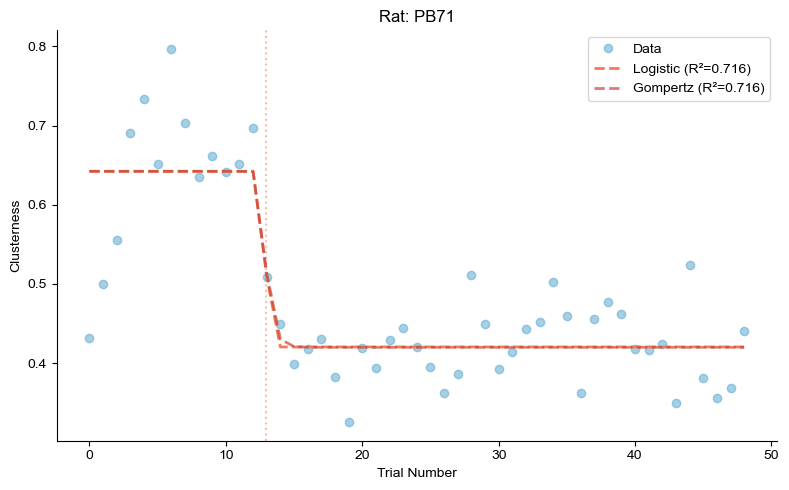


PB72 - Logistic fit:
  L=0.3876, x0=9.76, k=-0.2774, offset=0.3571
  R² = 0.8070
  Inflection point at trial 9.8
PB72 - Gompertz fit:
  L=0.4552, k=-0.1449, x0=10.85, offset=0.3597
  R² = 0.8052
  Inflection point at trial 10.9


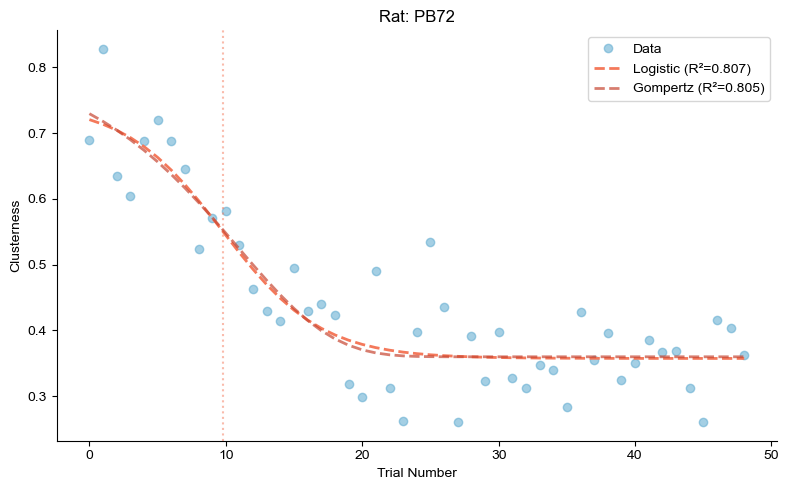


PB73 - Logistic fit:
  L=0.2364, x0=18.06, k=-0.3860, offset=0.3857
  R² = 0.7679
  Inflection point at trial 18.1
PB73 - Gompertz fit:
  L=0.2442, k=-0.2297, x0=19.69, offset=0.3870
  R² = 0.7636
  Inflection point at trial 19.7


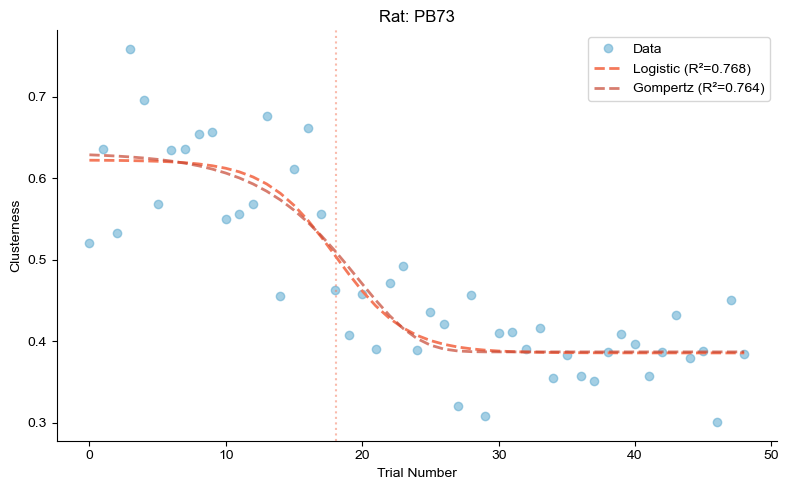


PB75 - Logistic fit:
  L=0.0953, x0=28.79, k=-3.8674, offset=0.3864
  R² = 0.4771
  Inflection point at trial 28.8
PB75 - Gompertz fit:
  L=0.0953, k=-3.1158, x0=28.96, offset=0.3864
  R² = 0.4772
  Inflection point at trial 29.0


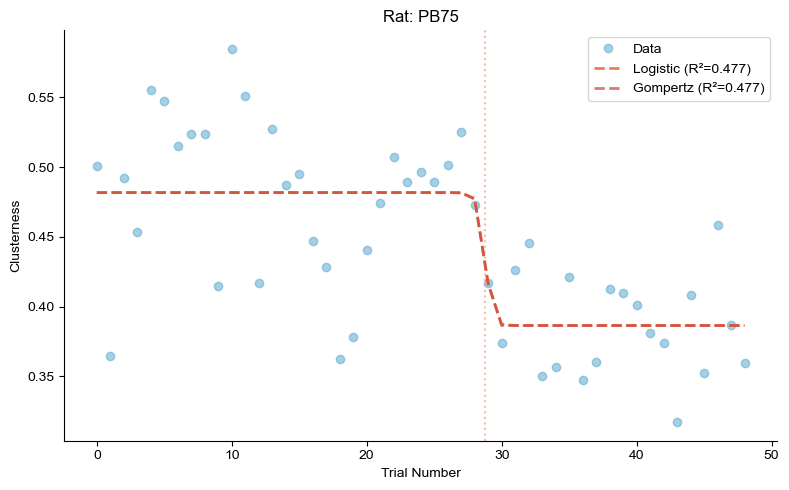

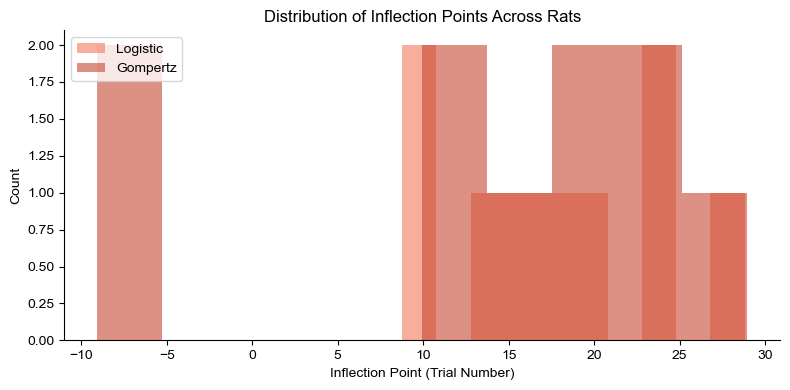


Mean inflection point (Logistic): 17.8 ± 6.3
Mean inflection point (Gompertz): 14.2 ± 12.3


In [81]:
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt

# Define sigmoid functions
def logistic(x, L, x0, k, offset):
    """
    L: amplitude of change
    x0: inflection point
    k: steepness (negative for decreasing)
    offset: lower asymptote
    """
    return L / (1 + np.exp(-k * (x - x0))) + offset

def gompertz(x, L, k, x0, offset):
    """
    Gompertz function - good for asymmetric sigmoids
    """
    return L * np.exp(-np.exp(-k * (x - x0))) + offset

# Store results
all_fits = []

df2_dep_45 = x_array.query("condition == 'deplete' & infusiontype == '45NaCl'").reset_index(drop=True)

for rat in df2_dep_45.id.unique():
    signal = x_array.query("id == @rat & condition == 'deplete' & infusiontype == '45NaCl'").clusterness_photo.values
    x = np.arange(len(signal))
    
    # Try logistic fit
    try:
        p0_logistic = [0.25, 15, -0.2, 0.35]  # amplitude, x0, k, offset
        popt_log, pcov_log = curve_fit(logistic, x, signal, p0=p0_logistic, maxfev=10000)
        
        y_fit_log = logistic(x, *popt_log)
        ss_res_log = np.sum((signal - y_fit_log) ** 2)
        ss_tot = np.sum((signal - np.mean(signal)) ** 2)
        r2_log = 1 - (ss_res_log / ss_tot)
        
        print(f"\n{rat} - Logistic fit:")
        print(f"  L={popt_log[0]:.4f}, x0={popt_log[1]:.2f}, k={popt_log[2]:.4f}, offset={popt_log[3]:.4f}")
        print(f"  R² = {r2_log:.4f}")
        print(f"  Inflection point at trial {popt_log[1]:.1f}")
        
    except Exception as e:
        print(f"\n{rat} - Logistic fit failed: {e}")
        popt_log = None
        r2_log = np.nan
    
    # Try Gompertz fit
    try:
        p0_gomp = [-0.25, -0.15, 15, 0.35]  # L, k, x0, offset
        popt_gomp, pcov_gomp = curve_fit(gompertz, x, signal, p0=p0_gomp, maxfev=10000)
        
        y_fit_gomp = gompertz(x, *popt_gomp)
        ss_res_gomp = np.sum((signal - y_fit_gomp) ** 2)
        r2_gomp = 1 - (ss_res_gomp / ss_tot)
        
        print(f"{rat} - Gompertz fit:")
        print(f"  L={popt_gomp[0]:.4f}, k={popt_gomp[1]:.4f}, x0={popt_gomp[2]:.2f}, offset={popt_gomp[3]:.4f}")
        print(f"  R² = {r2_gomp:.4f}")
        print(f"  Inflection point at trial {popt_gomp[2]:.1f}")
        
    except Exception as e:
        print(f"{rat} - Gompertz fit failed: {e}")
        popt_gomp = None
        r2_gomp = np.nan
    
    # Store results
    all_fits.append({
        'rat': rat,
        'logistic_params': popt_log,
        'logistic_r2': r2_log,
        'gompertz_params': popt_gomp,
        'gompertz_r2': r2_gomp
    })
    
    # Plot for this rat
    f, ax = plt.subplots(figsize=(8, 5))
    ax.plot(x, signal, 'o', label="Data", color=colors[0], alpha=0.6, markersize=6)
    
    if popt_log is not None:
        ax.plot(x, y_fit_log, '--', label=f"Logistic (R²={r2_log:.3f})", 
                color=colors[2], linewidth=2)
        ax.axvline(popt_log[1], color=colors[2], linestyle=':', alpha=0.5)
    
    if popt_gomp is not None:
        ax.plot(x, y_fit_gomp, '--', label=f"Gompertz (R²={r2_gomp:.3f})", 
                color=colors[3], linewidth=2, alpha=0.7)
    
    ax.set_xlabel("Trial Number")
    ax.set_ylabel("Clusterness")
    ax.set_title(f"Rat: {rat}")
    ax.legend()
    sns.despine(ax=ax)
    plt.tight_layout()
    plt.show()

# Summary plot - compare all inflection points
inflection_points_log = [fit['logistic_params'][1] for fit in all_fits if fit['logistic_params'] is not None]
inflection_points_gomp = [fit['gompertz_params'][2] for fit in all_fits if fit['gompertz_params'] is not None]

f, ax = plt.subplots(figsize=(8, 4))
if inflection_points_log:
    ax.hist(inflection_points_log, bins=10, alpha=0.6, label='Logistic', color=colors[2])
if inflection_points_gomp:
    ax.hist(inflection_points_gomp, bins=10, alpha=0.6, label='Gompertz', color=colors[3])
ax.set_xlabel('Inflection Point (Trial Number)')
ax.set_ylabel('Count')
ax.set_title('Distribution of Inflection Points Across Rats')
ax.legend()
sns.despine(ax=ax)
plt.tight_layout()
plt.show()

print(f"\nMean inflection point (Logistic): {np.mean(inflection_points_log):.1f} ± {np.std(inflection_points_log):.1f}")
print(f"Mean inflection point (Gompertz): {np.mean(inflection_points_gomp):.1f} ± {np.std(inflection_points_gomp):.1f}")

In [82]:
inflection_points_log

[np.float64(23.838723897819772),
 np.float64(8.76657760487721),
 np.float64(22.82880663208915),
 np.float64(15.744038752594768),
 np.float64(19.092398973405718),
 np.float64(12.979825242380961),
 np.float64(9.760807858828949),
 np.float64(18.060309681804846),
 np.float64(28.79295175525757)]

id: <built-in function id>, params: [-1.95833480e-18  4.99999999e+00 -9.99999984e-01]
id: <built-in function id>, params: [-1.95833480e-18  4.99999999e+00 -9.99999984e-01]
id: <built-in function id>, params: [-1.95833480e-18  4.99999999e+00 -9.99999984e-01]
id: <built-in function id>, params: [-1.95833480e-18  4.99999999e+00 -9.99999984e-01]
id: <built-in function id>, params: [-1.95833480e-18  4.99999999e+00 -9.99999984e-01]
id: <built-in function id>, params: [-1.95833480e-18  4.99999999e+00 -9.99999984e-01]
id: <built-in function id>, params: [-1.95833480e-18  4.99999999e+00 -9.99999984e-01]
id: <built-in function id>, params: [-1.95833480e-18  4.99999999e+00 -9.99999984e-01]
id: <built-in function id>, params: [-1.95833480e-18  4.99999999e+00 -9.99999984e-01]
id: <built-in function id>, params: [-1.95833480e-18  4.99999999e+00 -9.99999984e-01]
[-1.95833480e-18  4.99999999e+00 -9.99999984e-01            -inf]
[-1.95833480e-18  4.99999999e+00 -9.99999984e-01            -inf]
[-1.9583

C:\Users\jmc010\AppData\Local\Temp\ipykernel_19260\3138511051.py:19: RuntimeWarning: divide by zero encountered in scalar divide
  r_squared = 1 - (ss_res / ss_tot)
C:\Users\jmc010\AppData\Local\Temp\ipykernel_19260\3138511051.py:19: RuntimeWarning: divide by zero encountered in scalar divide
  r_squared = 1 - (ss_res / ss_tot)
C:\Users\jmc010\AppData\Local\Temp\ipykernel_19260\3138511051.py:19: RuntimeWarning: divide by zero encountered in scalar divide
  r_squared = 1 - (ss_res / ss_tot)
C:\Users\jmc010\AppData\Local\Temp\ipykernel_19260\3138511051.py:19: RuntimeWarning: divide by zero encountered in scalar divide
  r_squared = 1 - (ss_res / ss_tot)
C:\Users\jmc010\AppData\Local\Temp\ipykernel_19260\3138511051.py:19: RuntimeWarning: divide by zero encountered in scalar divide
  r_squared = 1 - (ss_res / ss_tot)
C:\Users\jmc010\AppData\Local\Temp\ipykernel_19260\3138511051.py:19: RuntimeWarning: divide by zero encountered in scalar divide
  r_squared = 1 - (ss_res / ss_tot)
C:\Users\j

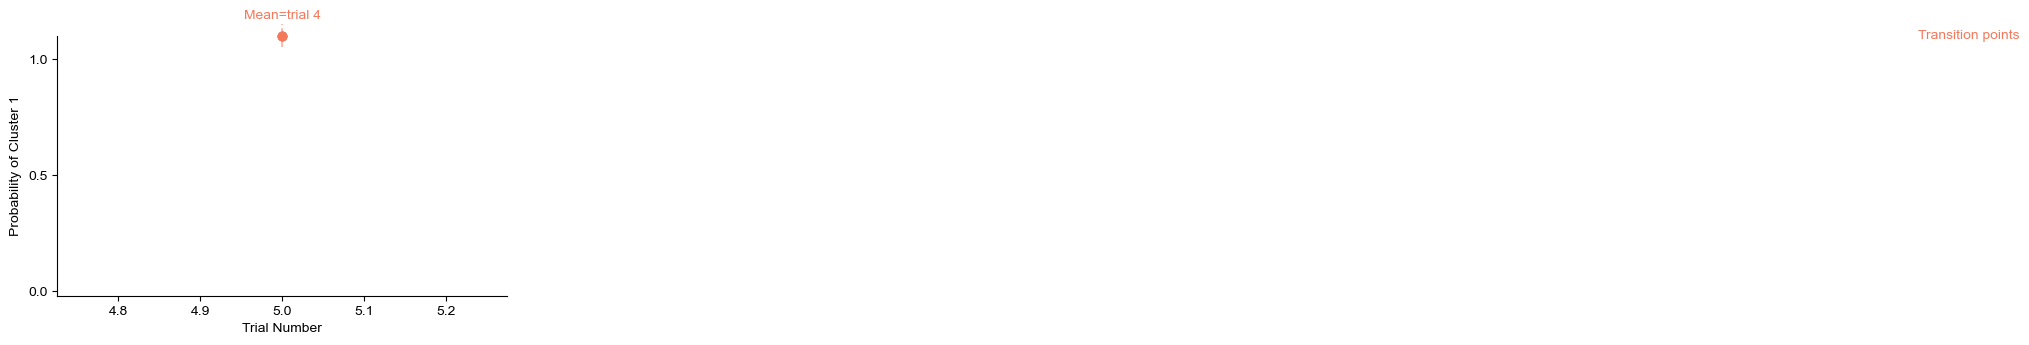

In [30]:
all_logistic_fits = []

df2_dep_45 = x_array.query("condition == 'deplete' & infusiontype == '45NaCl'").reset_index(drop=True)

for rat in df2_dep_45.id.unique():
    signal = x_array.query("id == @rat & condition == 'deplete' & infusiontype == '45NaCl'").clusterness_photo
    y = np.logical_not(signal).astype(int) # inverted signal
    
    x = np.arange(len(signal))

    try:
        popt, _ = curve_fit(logistic, x, y, p0=[1, 5, -1])  # Initial guesses for L, x0, k

        print(f"id: {id}, params: {popt}")

        y_fit = logistic(x, *popt)
        ss_res = np.sum((y - y_fit) ** 2)
        ss_tot = np.sum((y - np.mean(y)) ** 2)
        r_squared = 1 - (ss_res / ss_tot)

    except RuntimeError as e:
        print(f"Could not fit logistic for id {id}: {e}")
        r_squared = np.nan

    all_logistic_fits.append(np.concatenate([popt, [r_squared]]))

x = np.arange(len(signal))
colors = ["#67AFD2", "#016895", "#F4795B", "#C74632"]
     
f, ax = plt.subplots(figsize=(6, 4), gridspec_kw={'left': 0.2, 'right': 0.95, 'top': 0.85, 'bottom': 0.2})

for fit in all_logistic_fits:
    print(fit)
    if fit[0] < 0.5:
        continue
    ax.plot(x, logistic(x, *fit[:-1]), label="Fitted Logistic Function", linestyle="--", color=colors[2])
    
sns.despine(ax=ax)
ax.set_xlabel("Trial Number")
ax.set_ylabel("Probability of Cluster 1")

x0 = np.array(all_logistic_fits)[:,1]

ax.plot(x0, [1.1]*len(x0), marker="o", linestyle="None", color=colors[2], alpha=0.5, clip_on=False)
ax.text(np.max(x0)+2, 1.1, "Transition points", ha="left", va="center", fontsize=10, color=colors[2])

ax.plot([np.mean(x0), np.mean(x0)], [1.05, 1.15], color=colors[2], linestyle="--", alpha=0.5, clip_on=False)
ax.text(np.mean(x0), 1.16, f"Mean=trial {int(np.mean(x0))}", ha="center", va="bottom", fontsize=10, color=colors[2])

ax.set_yticks([0, 0.5, 1])
ax.set_ylim([-0.02, 1.1])

if savefigs:
    f.savefig(FIGSFOLDER / "logistic_fits_45NaCl.pdf", dpi=600, transparent=True)


In [ ]:
from scipy.spatial.distance import pdist, squareform, euclidean

for rat in rats:
    pc_rat = pca[x_array.query("id == 'PB26'").index, :5]  # First 3 PCs
    
    # Pairwise distances within this rat's data
    distances_rat = pdist(pc_rat, metric='euclidean')
    distance_matrix_rat = squareform(distances_rat)

    # f, ax = plt.subplots(figsize=(6,4))
    print(distances_rat.shape)

(4753,)
(4753,)
(4753,)
(4753,)
(4753,)
(4753,)
(4753,)
(4753,)
(4753,)
(4753,)


In [ ]:
x_array.cluster_photo

0       0
1       0
2       1
3       0
4       0
       ..
1955    1
1956    1
1957    1
1958    1
1959    1
Name: cluster_photo, Length: 1960, dtype: int64

PB26 (49,)
PB27 (49,)
PB30 (49,)
PB31 (49,)
PB46 (49,)
PB48 (49,)
PB71 (49,)
PB72 (49,)
PB73 (49,)
PB75 (49,)


C:\Users\jmc010\AppData\Local\Temp\ipykernel_19260\649613075.py:3: RuntimeWarning: Mean of empty slice.
  cluster_0_centroid = pca_data[labels == 0].mean(axis=0)
c:\Users\jmc010\.local\share\mamba\envs\default\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


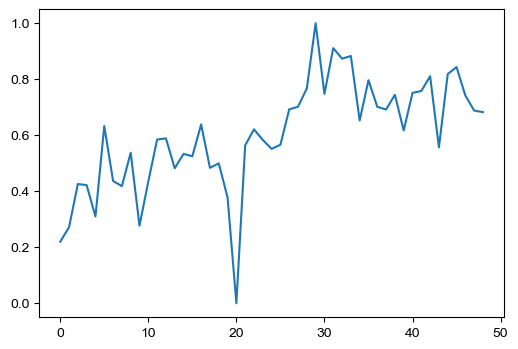

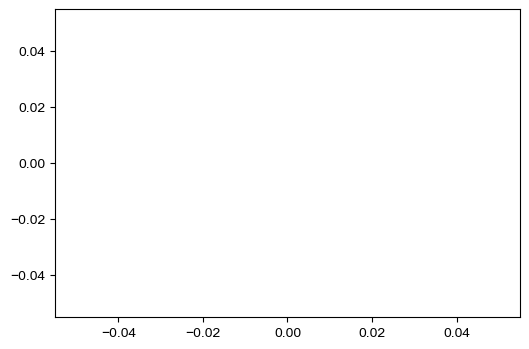

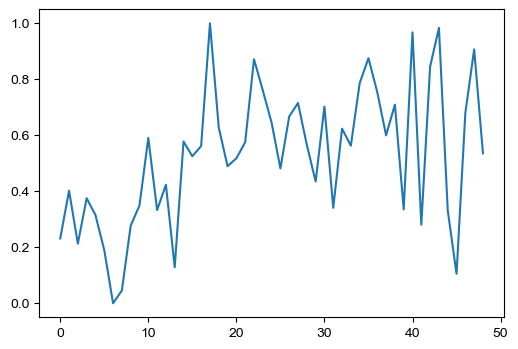

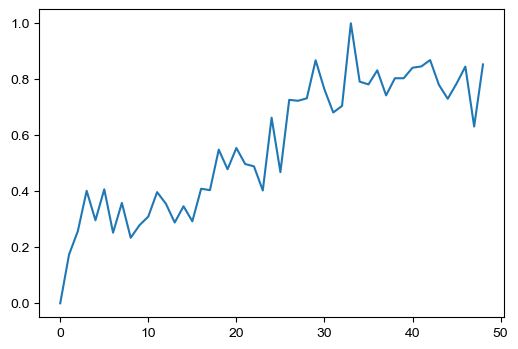

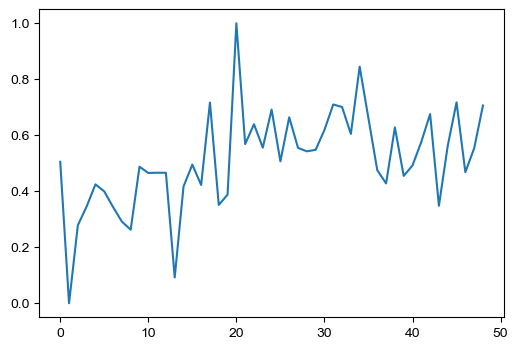

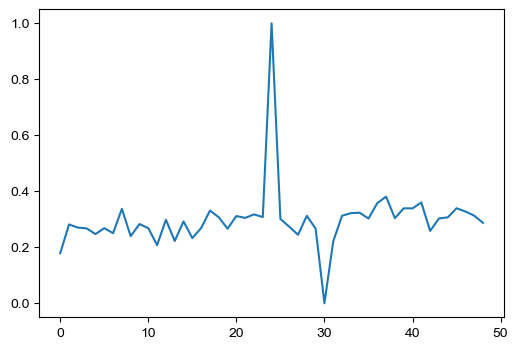

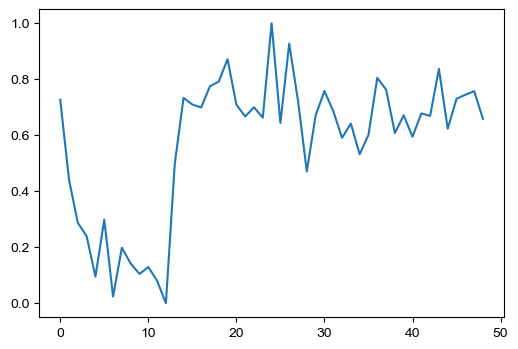

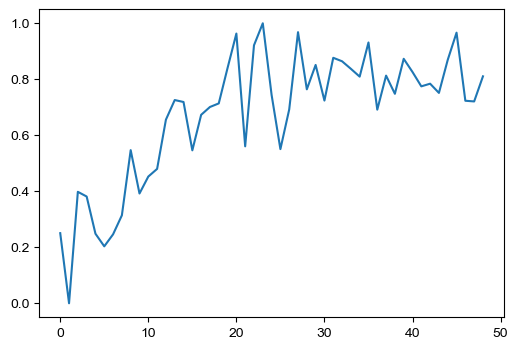

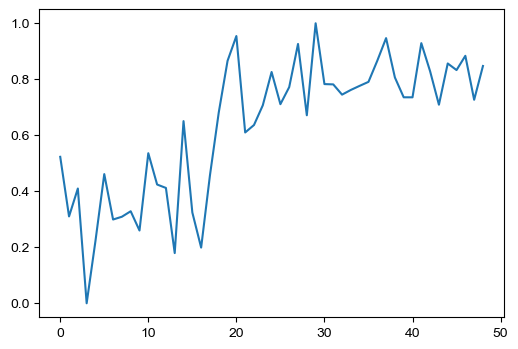

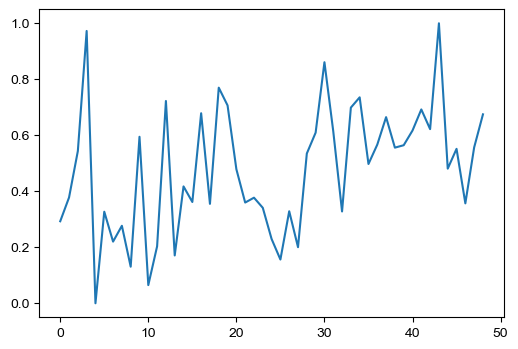

In [57]:
def get_normd_proj(pca_data, labels):
    # calculate centroids
    cluster_0_centroid = pca_data[labels == 0].mean(axis=0)
    cluster_1_centroid = pca_data[labels == 1].mean(axis=0)

    # Step 2: Define the cluster separation vector
    cluster_vector = cluster_1_centroid - cluster_0_centroid

    # Step 3: Project each observation onto the cluster vector
    # Normalize the cluster vector
    cluster_vector_norm = cluster_vector / np.linalg.norm(cluster_vector)
    # Compute projections
    projections = np.dot(pca_data - cluster_0_centroid, cluster_vector_norm)

    # Step 4: Normalize the projections to range between 0 and 1
    min_projection = projections.min()
    max_projection = projections.max()
    normalized_projections = (projections - min_projection) / (max_projection - min_projection)

    return normalized_projections

x_array_red = x_array.query("infusiontype == '45NaCl' & condition == 'deplete'")
rats = x_array_red.id.unique()
for rat in rats:
    pc_rat = pca[x_array_red.query("id == @rat").index, :3]  # First 3 PCs
    labels_rat = x_array_red.query("id == @rat").cluster_photo.values

    normd_proj_rat = get_normd_proj(pc_rat, labels_rat)
    print(rat, normd_proj_rat.shape)

    f, ax = plt.subplots(figsize=(6,4))
    ax.plot(normd_proj_rat)

Cross-correlation values: [  0.11577489   0.91101467   2.56308575   4.64168877   6.29587738
   7.5722267    9.49049373  10.73824395  11.01576828  14.55812988
  15.13194988  15.31759515  17.68658552  20.50523511  19.15669362
  19.92804291  20.26124679  21.84570351  22.19315525  22.83473109
  22.81398093  20.31224346  20.85587026  20.77043634  19.74854087
  18.90433883  19.5176056   17.2219036   19.79013473  20.89395918
  21.37275169  24.58897049  24.77192006  24.63365997  24.27212179
  22.37474205  21.93871103  16.30497946  16.37658943  15.33882288
  14.12913873  14.62581376  12.57185185  10.47354308   9.44331632
   7.6260504    6.63641635   6.06825667   5.45940563   5.81505136
   6.16263837   5.75765574   3.90967848   4.45917408   2.39116989
   1.98127944   2.42344905   1.03416225  -2.35332988  -3.59212902
  -4.30680958  -6.30591547  -7.63010651  -6.22408437  -7.74514843
  -8.29684592  -8.10714121  -9.81496847  -9.73572812  -9.3536283
  -8.16717299  -7.94985728  -6.86783825  -6.5320312

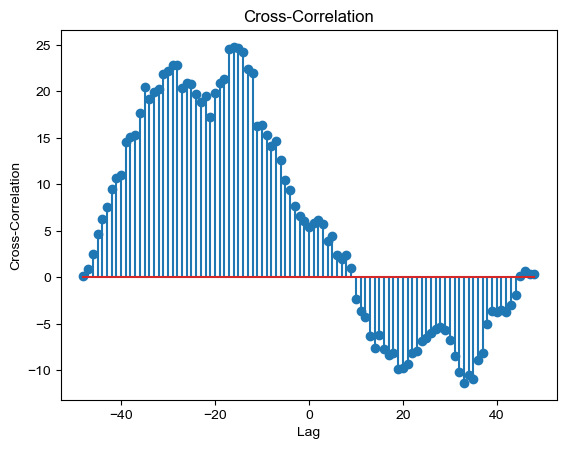

In [83]:
x_rat = x_array_red.query("id == @rat")


x = x_rat.clusterness_photo.values
y = x_rat.auc_vel.values



import numpy as np
import matplotlib.pyplot as plt
# Example signals
#x = np.array([1, 2, 3, 4, 5])
#y = np.array([0, 1, 2, 3, 4])
# Compute cross-correlation
cross_corr = np.correlate(x, y, mode='full')
# Lags
lags = np.arange(-len(x) + 1, len(x))
# Find the lag with the maximum correlation
max_corr_index = np.argmax(cross_corr)
best_lag = lags[max_corr_index]
print("Cross-correlation values:", cross_corr)
print("Best lag:", best_lag)
# Plot the cross-correlation
plt.stem(lags, cross_corr)
plt.title("Cross-Correlation")
plt.xlabel("Lag")
plt.ylabel("Cross-Correlation")
plt.show()

In [87]:
all_lags = []

for rat in rats:
    x_rat = x_array_red.query("id == @rat")

    x = x_rat.clusterness_photo.values
    y = x_rat.auc_vel.values

    cross_corr = np.correlate(x, y, mode='full')
    # Lags
    lags = np.arange(-len(x) + 1, len(x))
    # Find the lag with the maximum correlation
    max_corr_index = np.argmax(cross_corr)
    best_lag = lags[max_corr_index]

    all_lags.append(best_lag)

print("All best lags:", all_lags)

# lags are probably due to edge effects, let's think about cross-correlating smoothed data or a better measure than angular veloscity

All best lags: [np.int64(-28), np.int64(-4), np.int64(-32), np.int64(-29), np.int64(-13), np.int64(-22), np.int64(-21), np.int64(-34), np.int64(-31), np.int64(-16)]


In [67]:
x_rat.columns

Index(['trial', 'id', 'condition', 'infusiontype', 'cluster_photo',
       'cluster_vel', 'auc_snips', 'auc_vel', 'clusterness_photo',
       'clusterness_photo_smoothed'],
      dtype='object')

In [ ]:
all